In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.v2 as v2
from torchmetrics.functional import pairwise_cosine_similarity

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('./src')
from src.data import MultiSet, collate_bert

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
data_path = Path('./data/CytoSense')
annot = data_path / 'train.csv'

table = pd.read_csv(annot)

X = table.X.to_numpy()
img_files = [data_path / f'images/{x}.jpg' for x in X]
sig_files = [data_path / f'others/{x}.csv' for x in X]

In [5]:
dataset = MultiSet(data_path=data_path, annotation='train')
dataset

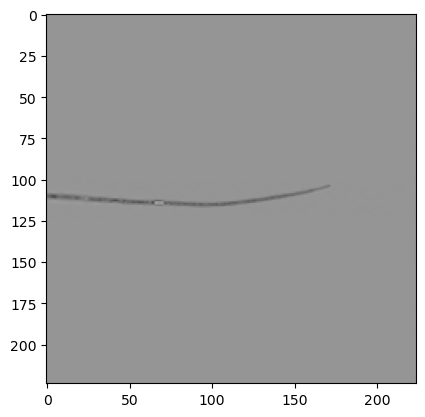

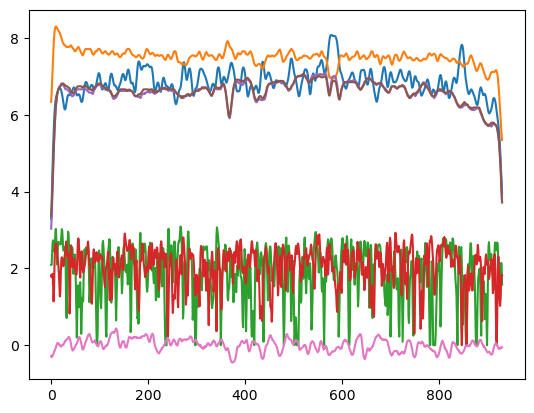

1097

In [24]:
ix = 110

image, signal, y = dataset[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
dataset.X[ix]

In [25]:
lens = [len(data[1]) for data in tqdm(dataset)]

100%|██████████| 800/800 [00:02<00:00, 338.18it/s]


array([110, 114,  61, 182, 113,  64, 196, 124, 112, 117])

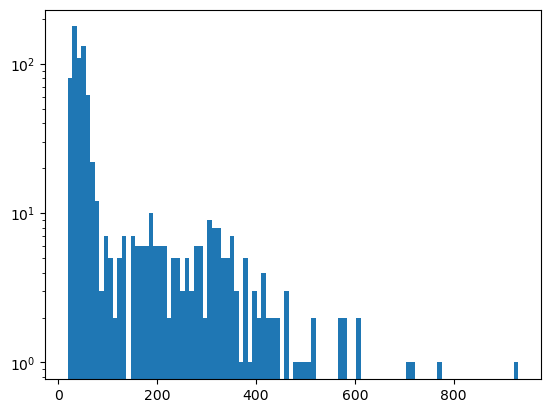

In [26]:
plt.hist(lens, bins=100)
plt.yscale('log')

np.argsort(lens)[::-1][:10]

In [11]:
dataloader = DataLoader(dataset=dataset, batch_size=20, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=collate_bert)

for batch in tqdm(dataloader):
    pass

batch = next(iter(dataloader))

100%|██████████| 40/40 [00:00<00:00, 43.25it/s]


In [28]:
image, signal, time, y = batch

image.shape, signal.shape, time.shape, y.shape

(torch.Size([50, 3, 224, 224]),
 torch.Size([50, 500, 7]),
 torch.Size([50, 500]),
 torch.Size([50]))

(tensor(1.), tensor(-1.))

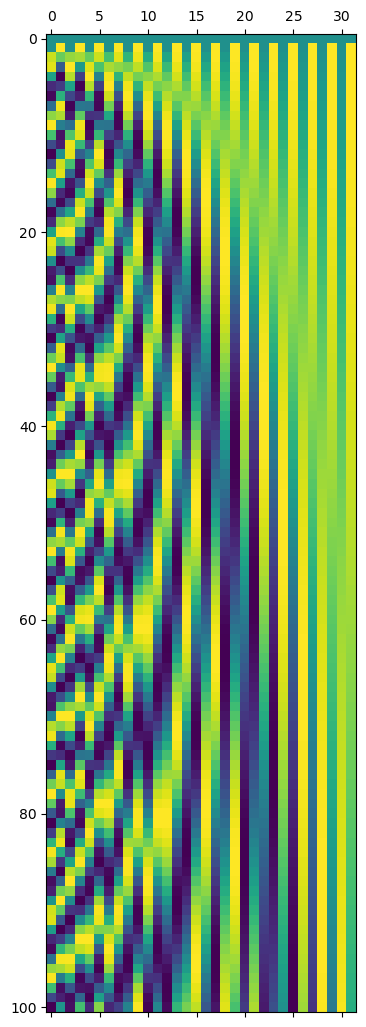

In [ ]:
MAX_LEN = 100
dim_emb = 32

idx = torch.arange(MAX_LEN).unsqueeze(1)
div_term = torch.exp(torch.arange(0, dim_emb, 2) * (-math.log(MAX_LEN) / dim_emb))

position = torch.zeros(MAX_LEN, dim_emb)
position[:, 0::2] = torch.sin(idx * div_term)
position[:, 1::2] = torch.cos(idx * div_term)
position = torch.cat((torch.zeros(1, dim_emb), position), 0)

position.shape
plt.matshow(position)

position.max(), position.min()

In [17]:
class TS_BERT(nn.Module):

    def __init__(self, dim_in=7, dim_emb=256, num_head=4, 
                 num_layers=4, dim_feedforward=512, dropout=0.1,
                 max_len=1000):
        super().__init__()

        self.embedding = nn.Linear(dim_in, dim_emb, bias=True)

        idx = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_emb, 2) * (-math.log(max_len) / dim_emb))
        position = torch.zeros(max_len, dim_emb)
        position[:, 0::2] = torch.sin(idx * div_term)
        position[:, 1::2] = torch.cos(idx * div_term)
        position = torch.cat((torch.zeros(1, dim_emb), position), 0)

        self.register_buffer('position', position)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim_emb, nhead=num_head, 
                dim_feedforward=dim_feedforward,
                dropout=dropout, activation='gelu', batch_first=True
            ),
            num_layers=num_layers
        )

    def forward(self, signal, time):
        x = self.embedding(signal) + self.position[time]
        mask = time == 0
        x = self.encoder(x, src_key_padding_mask=mask)
        return x

signal_encoder = TS_BERT()
signal_encoder.to(DEVICE)

TS_BERT(
  (embedding): Linear(in_features=7, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [12]:
image_encoder = torchvision.models.resnet18()
image_encoder.fc = nn.Linear(512, 256)
image_encoder.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
with torch.no_grad():
    out = signal_encoder(signal, time)

out[:, 0].shape

torch.Size([50, 128])

In [22]:
sum(p.numel() for p in image_encoder.parameters()), \
sum(p.numel() for p in signal_encoder.parameters())

(11307840, 2110464)

In [21]:
model = (image_encoder, signal_encoder)
params = list(image_encoder.parameters()) + list(signal_encoder.parameters())
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-10)

losses = []

In [20]:
# One training step (not epoch!)
def train_step(encoders, batch, optimizer):

    image_encoder, signal_encoder = encoders
    image_encoder.train()
    signal_encoder.train()

    image, signal, time = map(lambda x: x.to(DEVICE), batch[:-1])

    optimizer.zero_grad()

    I_f = image_encoder(image)
    S_f = signal_encoder(signal, time)[:, 0]

    I_e = nn.functional.normalize(I_f)
    S_e = nn.functional.normalize(S_f)

    logits = torch.matmul(I_e, S_e.T)

    labels = torch.arange(logits.shape[0]).to(DEVICE)
    loss_i = nn.functional.cross_entropy(logits, labels)
    loss_s = nn.functional.cross_entropy(logits.T, labels)
    loss = (loss_i + loss_s) / 2

    loss.backward()
    optimizer.step()

    return loss.detach().item()

In [23]:
steps = 40 * 3
iterator = tqdm(range(steps))

generator = iter(dataloader)
for _ in iterator:
    try:
        batch = next(generator)
    except StopIteration:
        generator = iter(dataloader)
        batch = next(generator)
    loss = train_step(model, batch, optimizer)
    losses.append(loss)
    iterator.set_description(f'{loss = :.5f}')

loss = 2.40678:  48%|████▊     | 57/120 [05:36<06:48,  6.49s/it]

: 

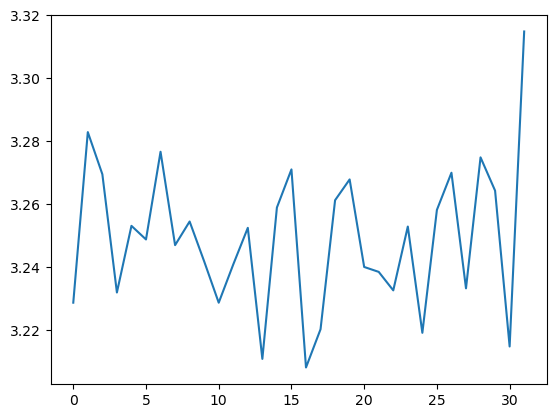

In [24]:
plt.plot(losses)

In [11]:
test_set = MultiSet(data_path, 'test')
test_loader = DataLoader(test_set, 100, collate_fn=collate_bert)

In [ ]:
lens = [len(data[1]) for data in tqdm(test_set)]

100%|██████████| 3501/3501 [00:13<00:00, 257.83it/s]


array([ 979,  556,  509, 1101, 1403,   44,  709, 1414,  221, 1231])

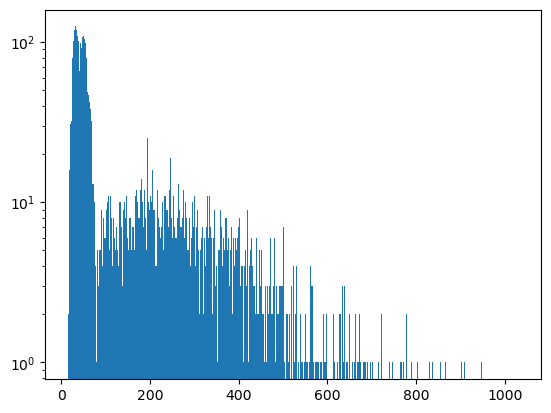

In [ ]:
plt.hist(lens, bins=500)
plt.yscale('log')

np.argsort(lens)[::-1][:10]

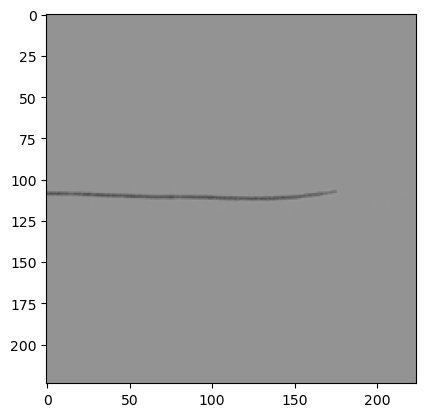

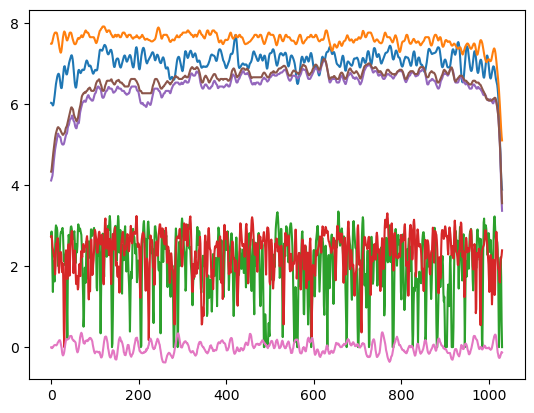

(148, 1031)

In [ ]:
ix = 979

image, signal, y = test_set[ix]

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.plot(signal)
plt.show()
test_set.X[ix], len(signal)

In [25]:
image_encoder.eval()
signal_encoder.eval()

I_e = []
S_e = []
label = []

for batch in tqdm(test_loader):
    image, signal, time, y = map(lambda x: x.to(DEVICE), batch)
    with torch.no_grad():
        I_e.append(image_encoder(image))
        S_e.append(signal_encoder(signal, time)[:, 0])
        label.append(y)

I_e = torch.cat(I_e)
S_e = torch.cat(S_e)
label = torch.cat(label)

100%|██████████| 36/36 [02:03<00:00,  3.42s/it]


In [26]:
I_e = I_e.numpy()
S_e = S_e.numpy()
label = label.numpy()

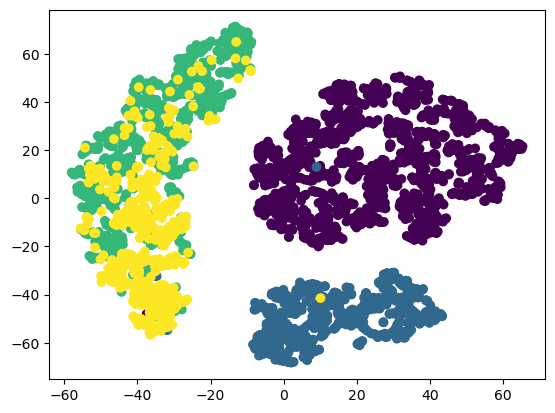

In [42]:
from sklearn.manifold import TSNE

ie = TSNE(2, perplexity=20, early_exaggeration=50).fit_transform(S_e)

plt.scatter(*zip(*ie), c=label)